# PCA Report for Arrests made in US

#### This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

In [272]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder, normalize
from sklearn.decomposition import PCA
from pca import pca


from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage



df = pd.read_csv('USArrests.csv')
# Correct city column by renaming to state
df.rename(columns={"City": "State"}, inplace=True)
print(f'Shape = {df.shape}')
df.head()


Shape = (50, 5)


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [274]:
# Convert all numerical fearues to the same datatype
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

There are 5 features within out dataframe. 

* There are 3 types of crimes (Murder, Assualt and Rape) and the numbers featured relate to the number of arrests made per 100,000 residents within each of the 50 states
* The Urban population for each state is also featured.

The aim of this report is to use PCA and hierarchical clustering to represent how each crime attributes itself to each state. We will impose segration on our data as state bring the response variable, while crime and population are our predictor values.


In [275]:
# check for any missing values
print(f'Checking for missing values:\n{df.isnull().sum()}')

Checking for missing values:
State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


In [276]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


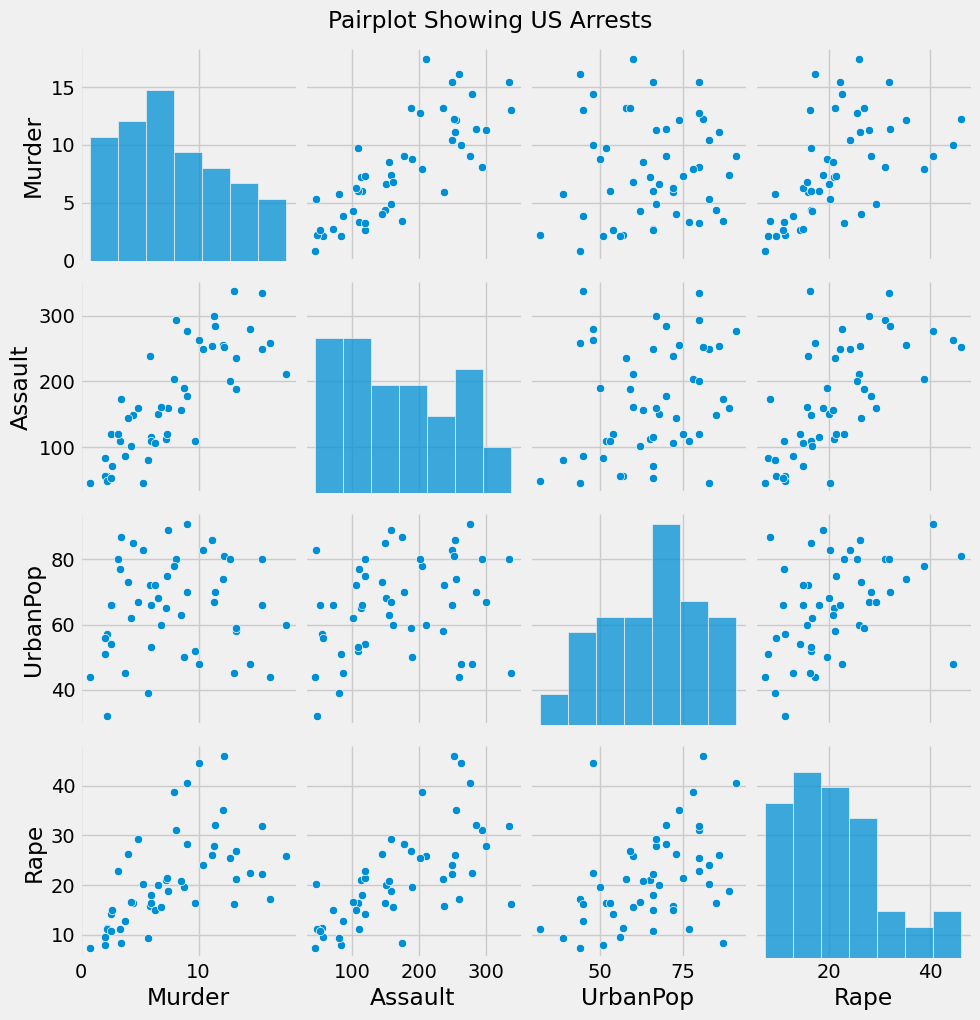

In [277]:
# use pairplots to see how the data is correlates
pp = sns.pairplot(df)
pp.fig.suptitle('Pairplot Showing US Arrests', y=1.02)
plt.show()


#### Observations

There are postive correlations between assault and rape,murder and rape, and between murder and assault.

There is also a slight postive correlation between UrbanPop and rape, but UrbanPop and assault and UrbanPop and murder are harder to disguish.

This can be seen further using a heatmap...

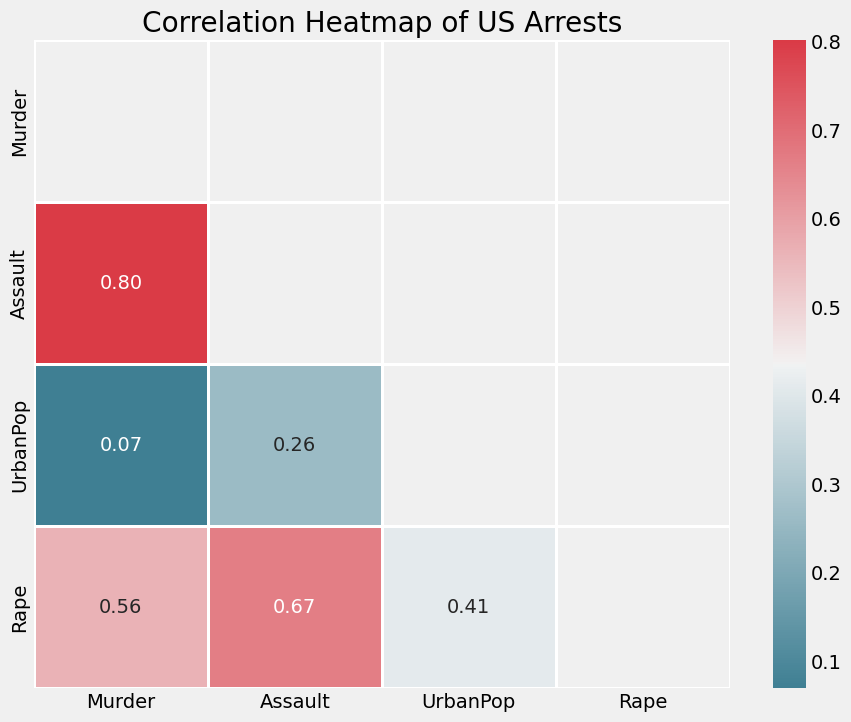

In [278]:
# look at how data features correlate with one another
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df_crimes):
  # get correlations
  Arrest_corrs = df_crimes.corr(numeric_only=True)
  # pick appropriate palette for heatmap
  # Plot figsize
  fig, ax = plt.subplots(figsize=(10, 8))
  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(Arrest_corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True
  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(Arrest_corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)
  plt.title('Correlation Heatmap of US Arrests')
  plt.show()

corr_heatmap(df)

Understanding distribution of our data is a vital aspect of producing accurate reports.

It is difficult to make comparisons between Urbanpop which is show as a percentage and the number of murders/rapes/assualts which are distinct numerical values.

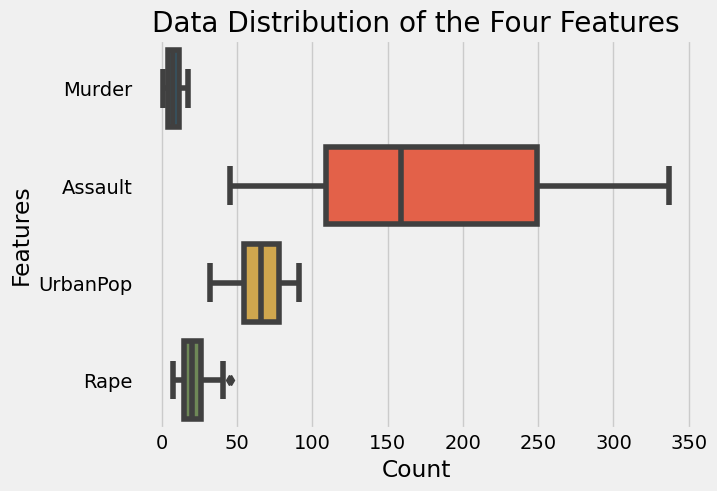

In [279]:
# Use boxplot to show distbution of each feature
sns.boxplot(data=df, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four Features')
plt.show()

#### Observations

There are more Assualt arrests recorded in the dataset than any other crime.

Murder has the lowest number of arrests recorded in the dataset.

Note: UrbanPop is a percentage so will not go beyond 100

### Data Scaling

In [280]:
# select and standardize features
X_scaled = StandardScaler().fit_transform(df.iloc[:, 1:5])
print(X_scaled.shape)

df_scale = pd.DataFrame(X_scaled, columns=df.columns[1:5])
df_scale.head()

(50, 4)


,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


### PCA

We are looking for a variance factor between 80% to 90% for our components. The absolute minmum threshold for variance should not be below 60% as this would open up a bias for unreliable data.

In [281]:
# Show how each component attributes 
pc = PCA().fit(df_scale)

pc.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

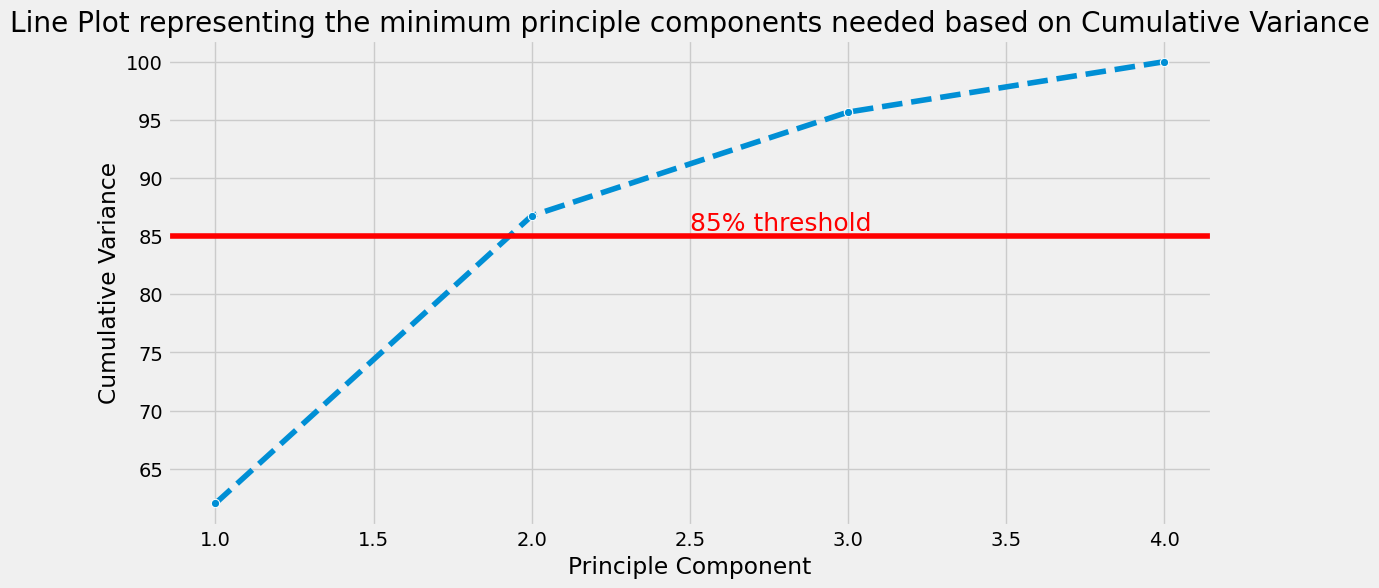

In [282]:
# create a graph to show the minumum number of components needed for analysis
X = np.arange(1, 5, step=1)
plt.figure(figsize=(12, 6))
sns.lineplot(x=X, y=np.cumsum(pc.explained_variance_ratio_)*100, linestyle='--', marker='o')
plt.title('Line Plot representing the minimum principle components needed based on Cumulative Variance')
plt.xlabel('Principle Component')
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='r', fontsize=18)
plt.show()

Based on the graph above we will proceed with working with 2 components

In [283]:
#proceed with 2 componetns
pc = PCA(n_components=2)

# obtain components
principal_components = pc.fit_transform(df_scale)
print(principal_components.shape)
# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, columns=['pc 1', 'pc 2'])
pca_df['State'] = df['State']
# This is to include the country code  as the rownames in the PC's
pca_df.set_index('State', inplace=True)
pca_df.head()

(50, 2)


,pc 1,pc 2
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


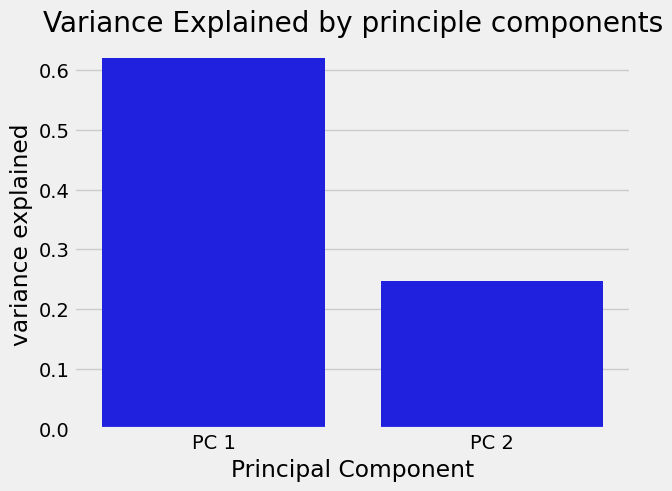

In [284]:
# create a barplot to visually represent how each Component affects the variance

variance_df = pd.DataFrame({'variance explained': pc.explained_variance_ratio_, 'Principal Component': ['PC 1', 'PC 2']})

plt.title('Variance Explained by principle components')
sns.barplot(x='Principal Component', y='variance explained', data=variance_df, color='b')
plt.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


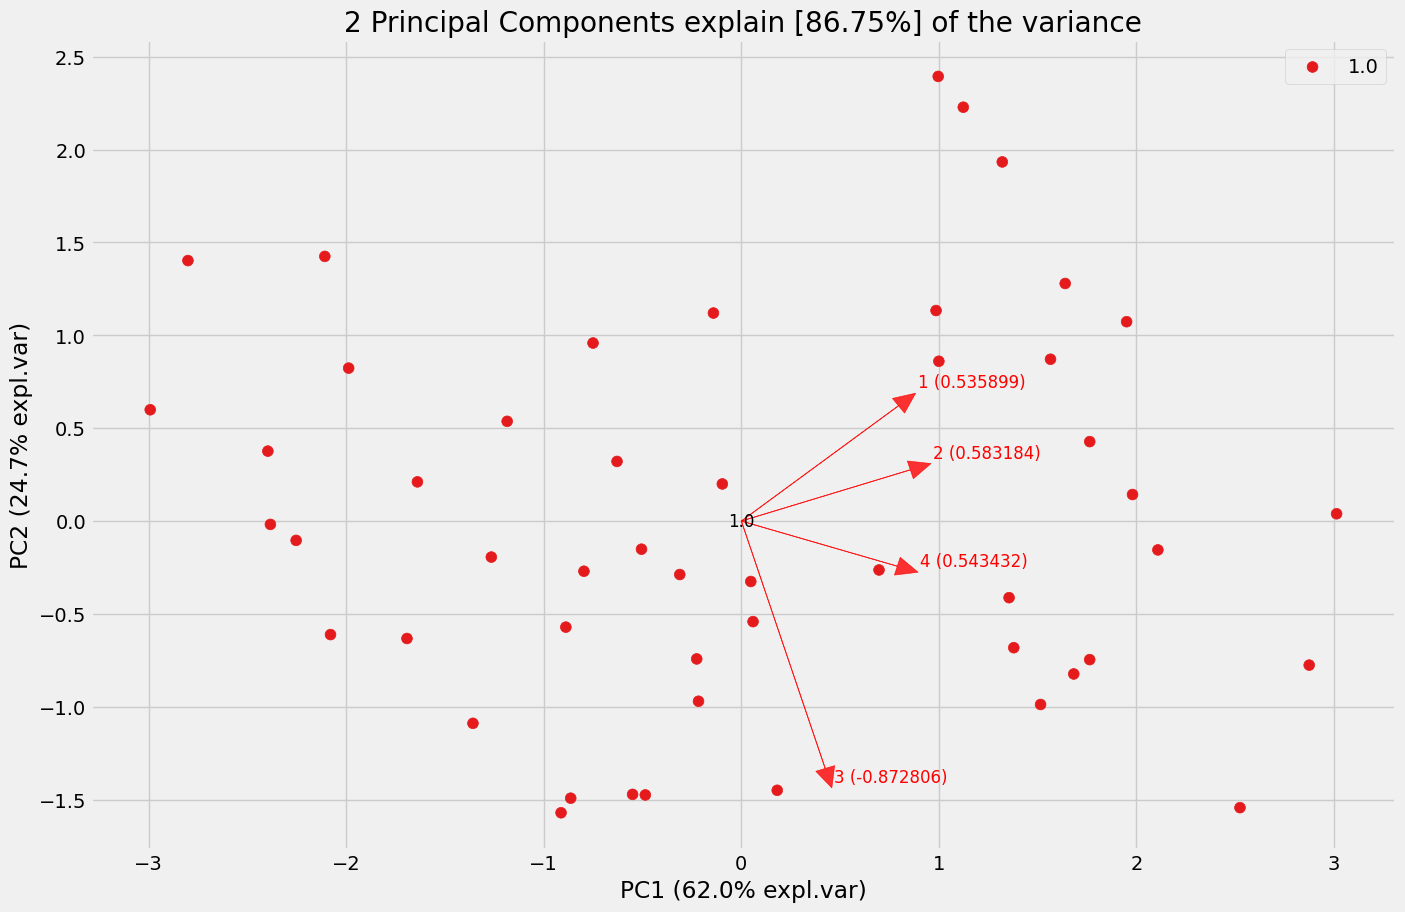

In [285]:
# create biplot to represent components within the total dataframe
model = pca(n_components=2)
results = model.fit_transform(X_scaled)

fig, ax = model.biplot(n_feat=4)

The above shows the obersations as point sin the plane formed by two principal components. The different states are all points on the biplot. Our data contained 4 variables (Murder, Assault, Urban Population and rape), which are all shown on the graph above (numbered 1 to 4).

Each variable has a positive correlation with the first Principle Component.  Urban Population, denoted by the number 3, has the relatively highest correlation with the 2nd principle component. Additionally it is the only negative correlation.

### Clustering Analysis

We will perform both K-means clustering Heirachical Clustering on this data and compare the results. I will adopt a Agglomerative strategy for clustering the US arrests data. This is a "bottom-up" approach: Each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

### Hierachical Clustering

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters. Hierarchical clustering has the advantage that we can see the clusters visually in a dendrogram and don’t have to specify the number of clusters before running the algorithm. However, we will have to decide the number of clusters after the algorithm runs.

For the distance metric between observations, Euclidean distance was used, which is the most common way to measure distance. In order to determine the method used to measure the distance between clusters, we plotted the various dendrograms for the single, complete, and average linkage methods.

In [286]:
# create the model with 0 clusters
hc = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc = hc.fit(pca_df)

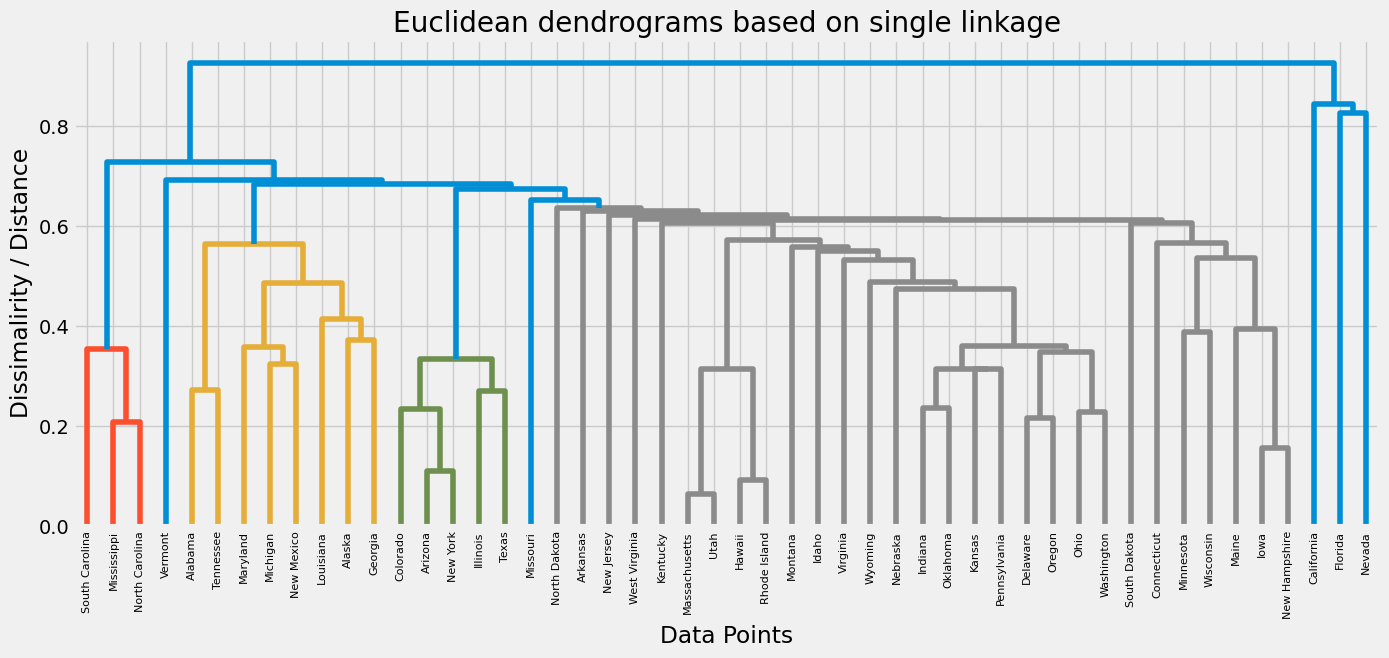

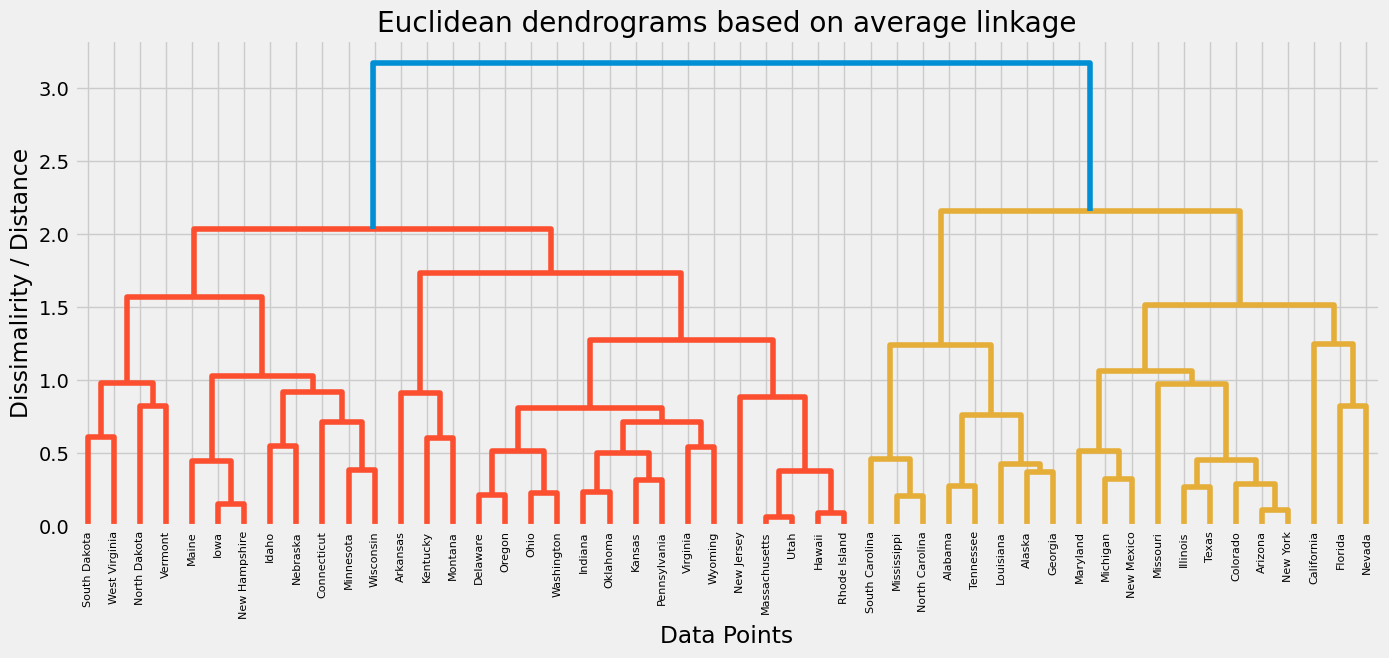

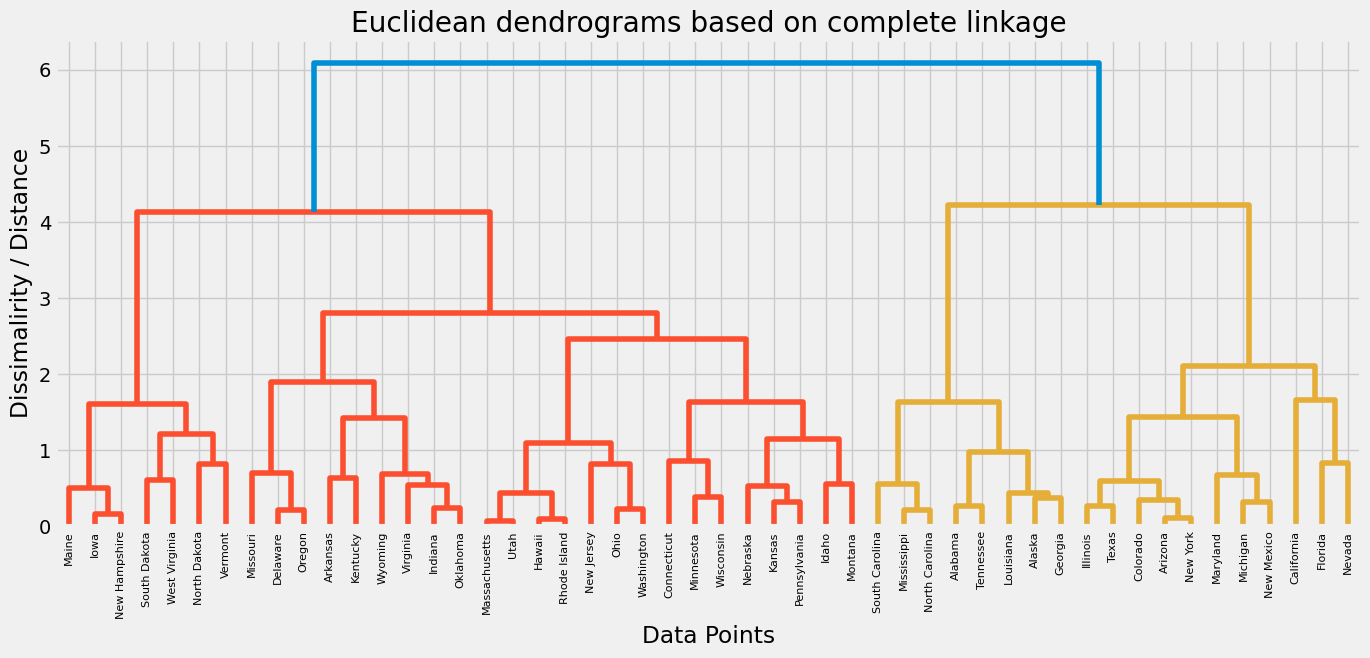

In [289]:
# plot dendrograms to work out the best linkage

# define linkage; take a small random selection of data
linkage_type = ['single','average', 'complete']
metric_type = 'euclidean'

for l in linkage_type:
    plt.figure(figsize=(15,6))
    ax = dendrogram(linkage(pca_df, method=l, metric=metric_type), labels=pca_df.index)   


    plt.title(f'{metric_type.capitalize()} dendrograms based on {l} linkage')

    plt.ylabel('Dissimalirity / Distance')
    plt.xlabel('Data Points')

    plt.show()

### Observations

#### In order to determine the method used to measure the distance between clusters, we plotted the various dendrograms for the single, complete, and average linkage methods. From the dendrograms above, the complete linkage method creates the most balanced dispersion of clusters.

In [293]:
# fit predictions over the training data using fit_predict to get siholhouette score
y_hc = hc.fit_predict(pca_df) 
print(f'Silhouette score for heirachical clustering method = {silhouette_score(principal_components, y_hc)}')

ValueError: Number of labels is 50. Valid values are 2 to n_samples - 1 (inclusive)

The silhouette score for this method comes out at 0.47, which is informative, but with room for improvement.

## K-Means clustering

K-means finds oberservations that share important characterisitcs and classifies them together into clusters.

We can use the K-means elbow method to work out the optimum number of clusters we need.


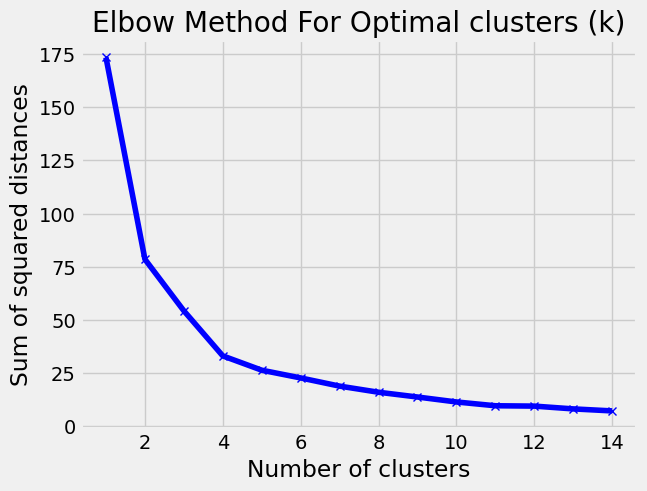

In [ ]:
# declare empty list to store results
def elbow_method(X):
    sum_of_squared_distances = []

    K = range(1, 15)
    for k in K:
        km = KMeans(n_clusters=k,  n_init=10)
        km.fit(X)
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal clusters (k)')
    plt.show()

elbow_method(pca_df)


#### If the plot looks like an arm, then the elbow on the arm is optimal k. In this case, the elbow runs from 2 to 4

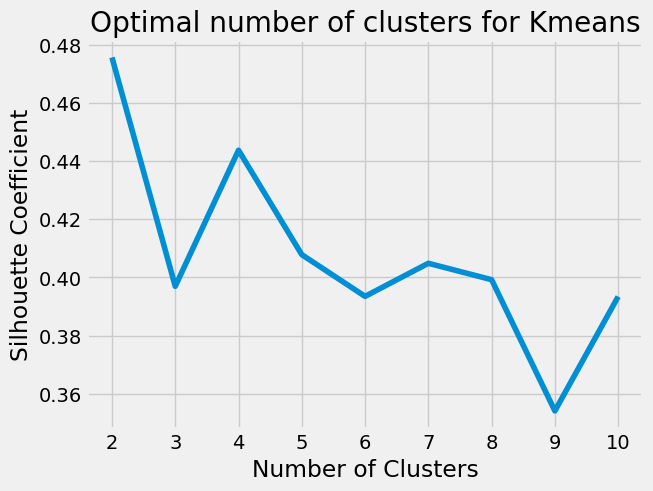

In [ ]:
# Verify the best number of clusters to use via the Silhouette score 
# from the elbow method above, we worked out the elbow was between 2 to 4. 
# Lets now test which once of these results in the best Silhouette score.
def get_silhouette_scores(X):
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []

    K = range(2,11)
    for k in K:
        km = KMeans(n_clusters=k, n_init=10)
        km.fit(X)
        # print(f'Number of clusters = {k} | Silhouette score = {silhouette_score(X, y_hc)}')
        score = silhouette_score(X, km.labels_)
        silhouette_coefficients.append(score)
    

    # visualise in plot
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)

    plt.title('Optimal number of clusters for Kmeans')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()


get_silhouette_scores(pca_df)

### Silhouette score
>1: Means clusters are well apart from each other and clearly distinguished.
><br><br>
>0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
><br><br>
>-1: Means clusters are assigned in the wrong way.
><br><br>

Based on these assumptions, using 2 x clusters performs the best using the Kmeans method and therefore the best one to use going fowards.

In [ ]:
states = pca_df.index
states

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


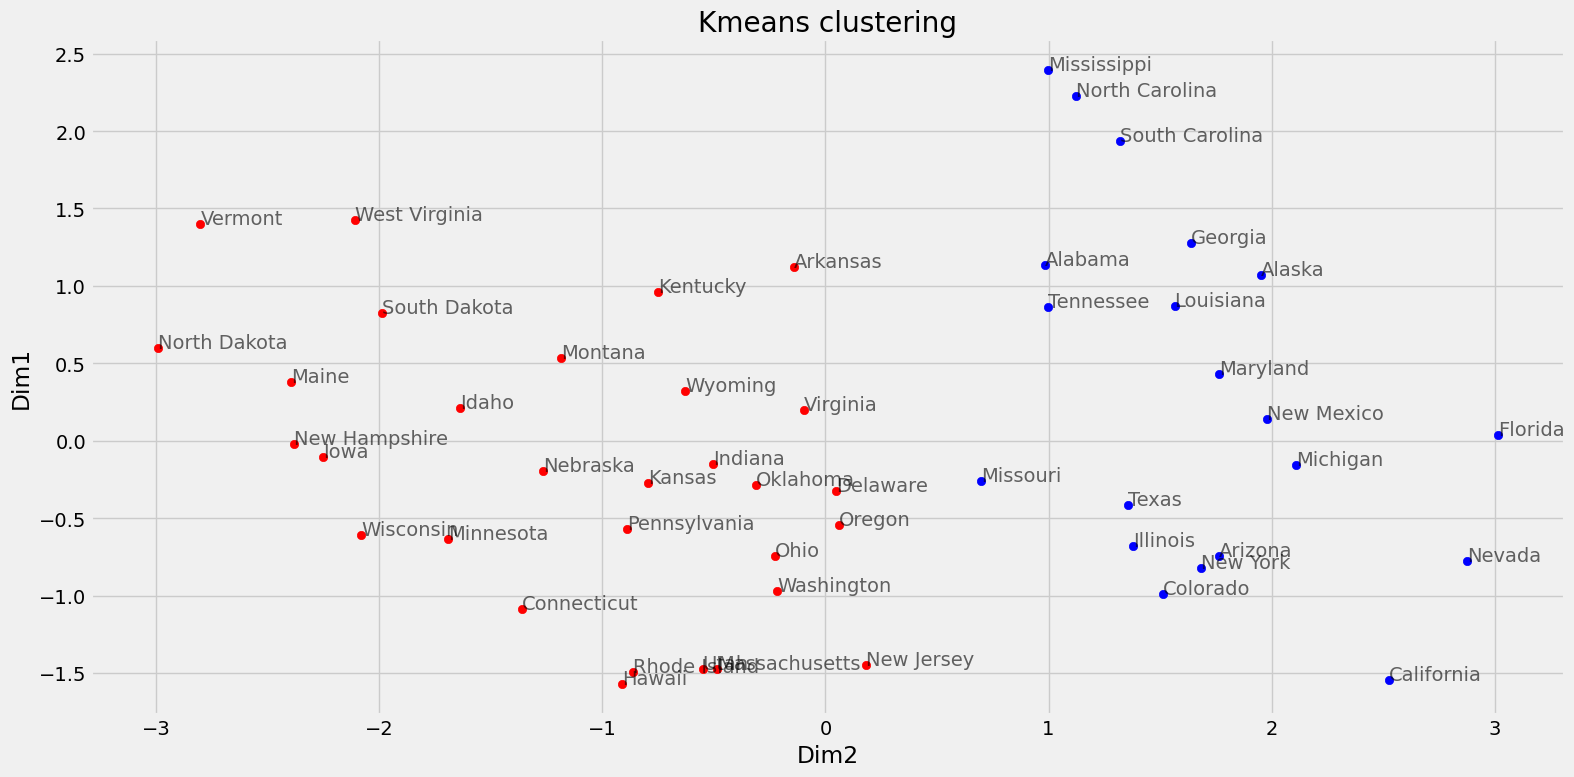

Silhouette Score for kMeans = 0.47580314770755616


In [294]:

# We extract the first two components
x = pca_df.iloc[:,0] 
y = pca_df.iloc[:,1] 

# set clusters equal to 2 
k = 2

# apply kmeans clustering
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
kmeans.labels_

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(16,8))

# set up the axes for the first plot
ax = fig.add_subplot()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]), alpha=0.6)

plt.title('Kmeans clustering')
ax.set_xlabel('Dim2')
ax.set_ylabel('Dim1')

plt.tight_layout()
plt.show()
print(f'Silhouette Score for kMeans = {silhouette_score(principal_components, kmeans.labels_)}')

### Oberservations

1. The kmeans method has produced a slightly higher Silohouette score of 0.48 opposed to 0.47 for the hierachical clustering method.

2. Both methods have a preference for 2 clusters

3. The first cluster formed contains a number of mid-states and eastern coastal states

4. The second cluster formed contains a mix of Western and southern states, with a few notable exceptions such as New York 

5. It would be interesting to note how the political allegiance of the states in these clusters aligns to the crime rates. e.g. is crime higher in Democratic or Replublican states?  Have the clustered formed around these political allegiances?